In [ ]:
import matplotlib.pyplot as plt
import importlib
import bitmap_editor
importlib.reload(bitmap_editor)
import numpy as np

height = 50
width = 50
bitmap_matrix = np.zeros(shape=(height,width))
bitmapEditor = bitmap_editor.BitmapEditor(bitmap_matrix)

Canvas(height=90, width=90)

In [602]:
for j,i in [(1,2), (3,4), (0,0)]:
    print(i)
    print(j)

2
1
4
3
0
0


73


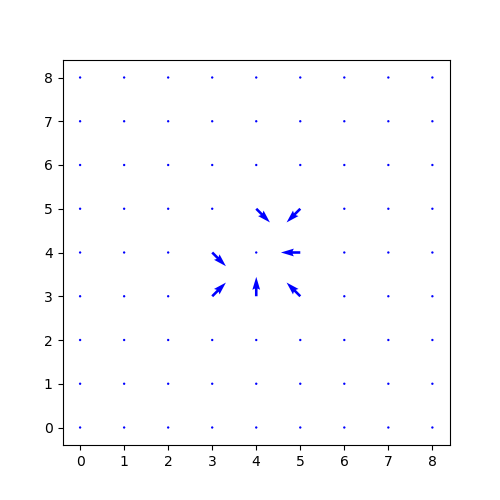

In [616]:
import navier_stokes
importlib.reload(navier_stokes)

grid = np.flip(np.copy(bitmap_matrix), 0)

######### Actual simulation code

cells = navier_stokes.cells(grid)
A, b = navier_stokes.projection_A(cells)

print(len(b))

################
X, Y = np.meshgrid(np.arange(width), np.arange(height))
NormalsU = np.zeros(shape=(height, width))
NormalsV = np.zeros(shape=(height, width))

for cell in cells.flat:
    normal = np.array([0, 0])
    if isinstance(cell, navier_stokes.BoundaryCell):
        normal = cell.normal
    NormalsU[cell.j][cell.i] = normal[0]
    NormalsV[cell.j][cell.i] = normal[1]


%matplotlib widget
fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, NormalsU, NormalsV, color="b", scale=20)
plt.show()

In [597]:

with np.printoptions(threshold=np.inf):
    print(A)

print(b)
print(len(b))
print(A.shape)

[[-4.   1.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [ 1.  -4.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0. ]
 [ 0.   1.  -4.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0. ]
 [ 0.   0.   1.  -4.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0. ]
 [ 0.   0.   0.   1.  -4.   1.   0.   0.   0.   0.   0.   1.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   

11
8.806141098011511e-08
[ 0.03266186  0.14715118  0.20411428  0.16268551  0.01896257 -0.14498269
 -0.22252604 -0.19489478 -0.09549999  0.03958193  0.19571907  0.28408435
  0.22703386 -0.01770157 -0.27569851 -0.35543157 -0.28255497 -0.13346476
  0.06341158  0.31205882  0.5094702   0.47906717 -0.04110421 -0.58467822
 -0.64094677 -0.44642876 -0.19538602  0.09739159  0.47963444  0.96267049
 -1.17724856 -0.66682728 -0.26506215  0.11158249  0.54641688  1.14070851
 -1.52025681 -0.77856967 -0.29542689  0.09794838  0.45374209  0.84984421
  1.26709639 -1.10495222 -0.6317677  -0.24965824  0.07612717  0.32075889
  0.53782986  0.65142706  0.45932729 -0.36180089 -0.5344078  -0.39389066
 -0.16938676  0.05518815  0.21533646  0.32928928  0.3414547   0.18447114
 -0.1387465  -0.27698745 -0.24000039 -0.11012532  0.03941431  0.15610951
  0.22253609  0.20063133  0.07584906 -0.1006688  -0.19479511 -0.17899814
 -0.08630229]
-0.0076491834880069685


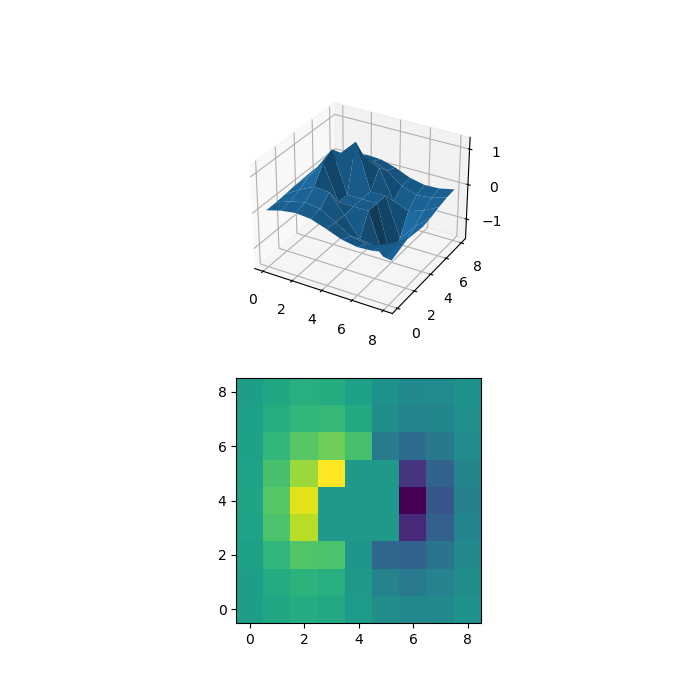

In [617]:
%matplotlib widget
import pyamg

ml = pyamg.ruge_stuben_solver(A)  # Build the multigrid hierarchy
residuals = []
x = ml.solve(b, tol=1e-8, maxiter=10, residuals=residuals)
print(len(residuals))
print(residuals[-1])
# x = np.linalg.solve(A,b)

print(x)

mesh = np.zeros(shape=(height,width))

avg = np.average(x)
print(avg)

for cell in cells.flat:
    if isinstance(cell, navier_stokes.ObstacleInteriorCell):
        mesh[cell.j][cell.i] = avg
        continue
    if isinstance(cell, navier_stokes.BoundaryCell):
        # TODO: Calculate the ghost cell value.
        mesh[cell.j][cell.i] = avg
        continue
    mesh[cell.j][cell.i] = x[cell.num]


fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(211, projection='3d')
ax2 = fig.add_subplot(212)
ax2.imshow(mesh, interpolation='none', origin='lower')

# plt.imshow(mesh, interpolation='none', origin='lower')
ax.plot_surface(X,Y,mesh) 
plt.show()

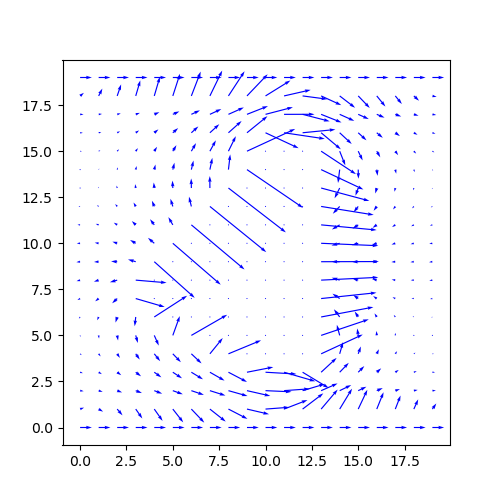

In [531]:
U = np.zeros(shape=mesh.shape)
V = np.zeros(shape=mesh.shape)

for fluid_cell in fluid_cells:
    if fluid_cell.boundary_normal is not None:
        continue

    j,i = fluid_cell.grid_index
    # xa = fluid_cells[fluid_cell.x_diff[0]].grid_index
    # xb = fluid_cells[fluid_cell.x_diff[1]].grid_index
    # xd = fluid_cell.x_diff[2]

    U[j][i] = (mesh[j][(i+1)%width] - mesh[j][(i-1)%width])/2
    V[j][i] = (mesh[j+1][i] - mesh[j-1][i])/2

newU = 1-U

for j,i in np.ndindex(mesh.shape):
    if grid[j][i]:
        newU[j][i]=0

fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, newU, -V, color="b")
# ax.quiver(X, Y, -U, -V, color="b")
# ax.quiver(X, Y, U,V, color="r")
plt.show()

# ax3.quiver(X,Y, 2-U, -V)

In [ ]:
A = np.array([[0,0,1], [0,0,0], [0,0,0]])

print(np.array((1,1)))
# print(len(A))
# obstacle_indices = (np.array(np.where(A == 1)).T - np.array([1,1])).tolist()

obstacle_indices = [(j-1,i-1) for j in range(3) for i in range(3) if A[j][i]]

# print(obstacle_indices)
# print(obstacle_indices)
# print([-1, 1] in obstacle_indices)

# print(np.array([1,1]) == np.abs(np.array([-1,1])))

# corner = np.abs(obstacle_indices[0]) == np.array([1,1])
# print(corner)
# print(np.abs(obstacle_indices[0]) == 
# if ():
#     print('corner')
# np.any([A[i]>8 for i in [(1,1),(2,2),(0,0)]])

In [264]:
np.sign(0)

0